# Comparing Computational Performance

HDBSCAN\*'s documentation has 
[a comprehensive performance comparison for clustering algorithm in Python](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html). 
This notebook compares FLASC's performance to HDBSCAN\* in a similar manner.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import time
import sklearn
import itertools

import numpy as np
import pandas as pd
from tqdm import trange, tqdm
from joblib.externals.loky import get_reusable_executor

from flasc import FLASC
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, KMeans
import fastcluster

import seaborn as sns
import matplotlib.pyplot as plt
from _plotting import *
%matplotlib inline
palette = configure_matplotlib()

## Configuration


### Generate Datasets
For this comparison, we generate data sets with `num_dims` features using 5 random walks containing 50 data points each starting from `num_cluster` distinct points. The resulting clusters and random walks can overlap in such a way that more or fewer clusters will be deteced. In addition, they provide more interesting and varied density distributions and branching patterns than Gaussian blobs. The varying structures should provide a broader picture of FHDBSCAN's performance.

In [4]:
def generate_cluster(n_dims=2, n_walks=5, walk_length=50, std_step=0.1):
    """Generates a cluster by repeating a random walk from (0,0)."""
    # The possible directions
    vectors = np.eye(n_dims)
    # Output collection
    points = []
    # Sample random walks
    for r in range(n_walks):
        directions = np.random.choice(np.arange(n_dims), walk_length)
        lengths = np.random.normal(0, std_step, (walk_length, 1))
        steps = vectors[directions] * lengths
        pts = np.cumsum(steps, axis=0)
        points.append(pts)
    # Add noise
    points = np.concatenate(points)
    return points

To simplify interpreting the run time results later on, we want to avoid that too many clusters overlap and merge. Therefore, we compute the 95 percentile distance-to-center for 10 generated clusters with 2, 8, and 16 dimensions. This value indicates how far clusters tend to spread away from their starting point, which we can use to specify a volume large enough to fit the specified number of clusters.

In [5]:
from sklearn.metrics import pairwise_distances

repeats = 10
n_dims = [2, 8, 16]
dist_to_center = [[] for _ in range(len(n_dims))]

for i, d in enumerate(n_dims):
    for j in range(repeats):        
        X = generate_cluster(n_dims=d)
        dist_to_center[i] += [pairwise_distances([[0] * d], X)[0]]

cluster_spread = np.asarray([np.percentile(np.concatenate(d), 95) for d in dist_to_center])
cluster_spread

array([0.9090782 , 0.84162138, 0.77375962])

Using these distances, we can generate datasets with multiple clusters by sampling uniform random starting points
in a volume that fits 5 times the specified number of clusters.

In [6]:
from sklearn.utils import shuffle

def generate_clusters(n_clusters=2, n_dims=2, min_dist=1):
    # Uniform random samples within volume spaced to fit 5*n_clusters
    extra_spacing_factor = 5
    volume = n_clusters * (min_dist**n_dims)
    length = np.power(extra_spacing_factor * volume, 1./n_dims)
    coords = np.random.uniform(high=length, size=(n_clusters, n_dims))

    # Perform random walks at each coord
    points = np.concatenate([
        generate_cluster(n_dims=n_dims) + coord
        for coord in coords
    ])
    # Create labels and return
    y = np.repeat(np.arange(n_clusters), 250)
    return shuffle(points, y)

Now, to actually generate the datasets, we vary the number of clusters from 2 to 800 in 10 exponentially spaced steps.

In [7]:
num_dims = np.asarray(n_dims)
repeats = np.asarray(list(range(10)))
num_clusters = np.round(np.exp(np.linspace(np.log(2), np.log(800), 10)))

params = pd.DataFrame([
        (x[0][0], x[0][1], x[1], x[2])
        for x in itertools.product(
            zip(num_dims, 2 * cluster_spread), num_clusters, repeats
        )
    ], columns = ['num_dims', 'min_dist', 'num_clusters', 'repeat']
)

In [8]:
params['X'], params['y'] = tuple(zip(*[
    generate_clusters(
        n_clusters=int(params.num_clusters[i]),
        n_dims=int(params.num_dims[i]),
        min_dist=float(params.min_dist[i])
    )
    for i in trange(params.shape[0])
]))
params.to_pickle('./data/generated/performance_comparison_datasets.pickle')

100%|██████████| 300/300 [00:04<00:00, 63.98it/s] 


## Run parameter sweep

Each algorithm is evaluated on each generated data set once. A timeout limit of 
80 seconds is used so data sets larger than the first one exceeding the time 
limit are not evaluated for each algorithm individually. We record the run time 
and number of detected clusters (except for `fastcluster`).

The HDBSCAN\* and FLASC parameters are tuned to detect clusters and branches 
with the expected sizes.

In [9]:
max_time = 80 # seconds
algorithms = ['fastcluster', 'kmeans', 'hdbscan', 'flasc (full)', 'flasc (core)']
sweep =  pd.DataFrame([
        (x[0], x[1], x[2])
        for x in itertools.product(num_dims, num_clusters, algorithms)
    ], columns = ['num_dims', 'num_clusters', 'algorithm']
)

class FastclusterWrapper:
    def fit(self, X):
        return fastcluster.linkage_vector(X)

clusterers = {
    'flasc (full)': FLASC(min_samples=10, min_cluster_size=100, min_branch_size=20, branch_detection_method='full', allow_single_cluster=True, num_jobs=1),
    'flasc (core)': FLASC(min_samples=10, min_cluster_size=100, min_branch_size=20, branch_detection_method='core', allow_single_cluster=True, num_jobs=1),
    'hdbscan': HDBSCAN(min_samples=10, min_cluster_size=100, allow_single_cluster=True, core_dist_n_jobs=1),
    'fastcluster': FastclusterWrapper(),
    'kmeans': KMeans(n_init=1)
}

In [10]:
limits = {}

def measure_setting(p):
    """Computes the run times of the given setting"""
    # Allocate output
    num_repeats = len(repeats)
    times = np.nan * np.ones(num_repeats, dtype=np.double)
    num_edges = np.nan * np.ones(num_repeats, dtype=np.double)
    labels = [None] * num_repeats

    # Skip this setting if a smaller size already went over time.
    if p.algorithm in limits and p.num_clusters > limits[p.algorithm]:
        return times, labels, num_edges
    
    # Extract the clusterer and arguments
    clusterer = clusterers[p.algorithm]
    if p.algorithm == 'kmeans':
        clusterer.n_clusters=int(p.num_clusters)
    
    # Evaluate num_repeat times
    for i in range(num_repeats):
        param_i = params[
            (params.num_dims == p.num_dims) &
            (params.num_clusters == p.num_clusters) &
            (params.repeat == i)
        ].index[0]
        
        # # Shutdown pool
        # get_reusable_executor().shutdown(wait=True)
        
        # Time the evaluation
        X = params.loc[param_i, 'X']
        start = time.perf_counter()
        clusterer.fit(X)
        end = time.perf_counter()
        
        # Store the time, labels, and num edges
        times[i] = (end-start)
        if p.algorithm != 'fastcluster':
            labels[i] = clusterer.labels_.copy()
        if 'flasc' in p.algorithm:
            num_edges[i] = clusterer.cluster_approximation_graph_._edges.shape[0]
        
        # Early stop if algorithm goes over time
        if (end-start) > max_time:
            limits[p.algorithm] = p.num_clusters
    
    return times, labels, num_edges

The cell below actually evaluates all the settings and runs in about 2 hours!

In [11]:
sweep['results'] = [ measure_setting(sweep.iloc[i]) for i in trange(sweep.shape[0]) ]
sweep.to_pickle('./data/generated/performance_comparison.pickle')

100%|██████████| 150/150 [2:16:19<00:00, 54.53s/it] 


Also reformats the data frame so that each row represents a single dataset/algorithm combination:

In [12]:
melt = sweep.copy()
melt['run_times'] = melt.results.apply(lambda x: x[0])
melt['labels'] = melt.results.apply(lambda x: x[1])
melt['num_edges'] = melt.results.apply(lambda x: x[2])
melt['repeats'] = [repeats for _ in range(melt.shape[0])]
melt['num_points'] = [
    params.loc[(params.num_dims == sweep.num_dims[i]) &
               (params.num_clusters == sweep.num_clusters[i]) &
               (params.repeat == 0), 'X'].iloc[0].shape[0]
    for i in range(sweep.shape[0])
]
melt = melt.drop(columns=['results'])
melt = melt.explode(['run_times', 'labels', 'num_edges', 'repeats'], ignore_index=True)
melt['num_noise_points'] = melt.labels.apply(lambda l: None if l is None else np.sum(l == -1))
melt['num_detected_clusters'] = melt.labels.apply(lambda l: None if l is None else len(np.unique(l)) - int(-1 in l))
melt.repeats = melt.repeats.astype(np.intp)
melt.num_noise_points = melt.num_noise_points.astype(np.double)
melt.num_detected_clusters = melt.num_detected_clusters.astype(np.double)
melt.run_times = melt.run_times.astype(np.double)
melt.num_edges = melt.num_edges.astype(np.double)
melt.to_pickle('./data/generated/performance_comparison_melt.pickle')

## Plotting

First, the datasets are read-in to enable re-plotting without running the sweeps. Variables are renamed to avoid "_" characters that break the latex formatting.

In [3]:
params = pd.read_pickle('./data/generated/performance_comparison_datasets.pickle')
sweep = pd.read_pickle('./data/generated/performance_comparison.pickle')
melt = pd.read_pickle('./data/generated/performance_comparison_melt.pickle')
melt.run_times.replace(0.0, np.nan, inplace=True)
num_dims = sweep.num_dims.unique()

sweep.algorithm = sweep.algorithm.replace({
    'hdbscan': "HDBSCAN*",
    'flasc (full)': "FLASC (full)",
    'flasc (core)': "FLASC (core)",
    'kmeans': 'kMeans'
})

melt.algorithm = melt.algorithm.replace({
    'hdbscan': "HDBSCAN*",
    'flasc (full)': "FLASC (full)",
    'flasc (core)': "FLASC (core)",
    'kmeans': 'kMeans'
})

In [4]:
display_names = {
    'columns': {
        'num_dims': 'Num dimensions',
        'num_points': 'Num points',
        'num_clusters': 'Num clusters',
        'num_detected_clusters': 'Num detected clusters',
        'num_noise_points': 'Num noise points',
        'run_times': 'Run time (s)',
        'num_edges': 'Num edges',
        'speedup': 'Speedup',
        'algorithm': 'Algorithm'
    }
}

The figures below show the run-times for 2, 8, and 16 dimensions:

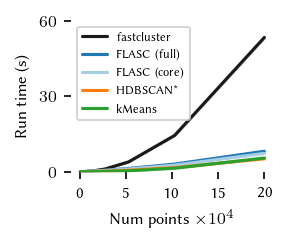

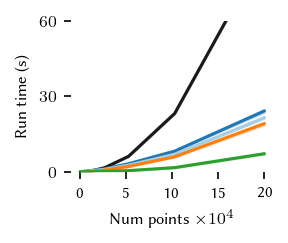

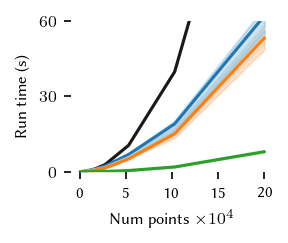

In [5]:
nu_dims = len(num_dims)
ylim = [60, 60, 60] #[15, 40, 80]
ticks = [[0, 30, 60] for _ in range(3)] #[[0, 5, 10, 15], [0, 20, 40], [0, 40, 80]]
for i, nd in enumerate(num_dims):
    sized_fig(1/nu_dims, aspect=0.8)
    sns.lineplot(melt.query(f'num_dims == {nd}').rename(**display_names), 
                 x='Num points', y='Run time (s)', hue='Algorithm', 
                 legend=False if i > 0 else "auto",
                 hue_order=[
                    "fastcluster", "FLASC (full)", "FLASC (core)",
                    "HDBSCAN*", 'kMeans',
                ],
                palette=['k', 'C0', '#a6cee3', 'C1', 'C2']
                )
    plt.gca().set_xticks([0, 50000, 100000, 150000, 200000])
    plt.gca().set_xticklabels(['0', '5', '10', '15', '20'])
    if i == 0:
        l = plt.legend(loc='upper left', title_fontsize=6, fontsize=6)
        adjust_legend_subtitles(l)
    plt.xlabel(f'Num points $\\times 10^4$')
    plt.ylim([0, ylim[i]])
    plt.yticks(ticks[i])
    plt.subplots_adjust(0.24, 0.26, 0.98, 0.95, 0, 0)
    plt.savefig(f'./images/run_times_{nd:d}_dims.png')
    plt.show()

In general, FLASC's performance scales similarly to HDBSCAN\*, especially when
the data has more than 2 dimensions. 

As expected, the *core* detection method results in shorter run-times compared
to the *full* detection method, especially with more dimensions.

What follows are a couple of validation plots used to ensure that FLASC detects
clusters with branches and does not classify too many points as noise. First the
number of detected groups:

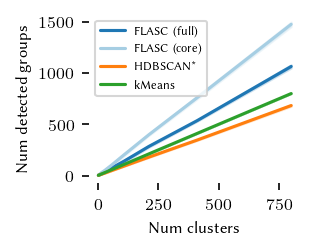

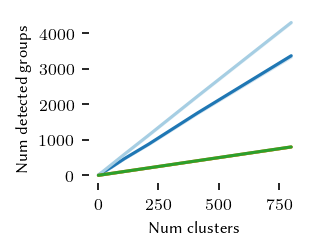

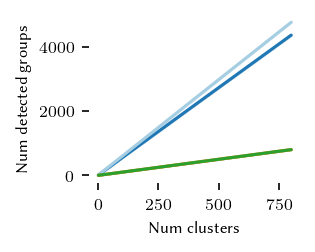

In [7]:
nu_dims = len(num_dims)
for i, nd in enumerate(num_dims):
    sized_fig(1/nu_dims, aspect=0.8)
    sns.lineplot(melt.query(f'num_dims == {nd}').rename(**display_names), 
                 x='Num clusters', y='Num detected clusters', hue='Algorithm', 
                 legend=False if i > 0 else "auto",
                 hue_order=[
                    "FLASC (full)", "FLASC (core)", "HDBSCAN*", "kMeans"
                 ],
                 palette=['C0', '#a6cee3', 'C1', 'C2'])
    plt.ylabel('Num detected groups')
    if i == 0:
        l = plt.legend(loc='upper left', title_fontsize=6, fontsize=6)
        adjust_legend_subtitles(l)
    plt.show()

The curve for kMeans and HDBSCAN\* match the number of generated clusters. Both
FLASC variants detect more labels than clusters, indicating that branches are
found.

Now for the number of noise points:

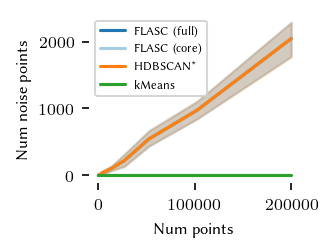

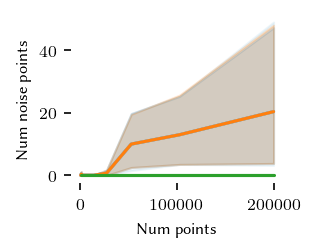

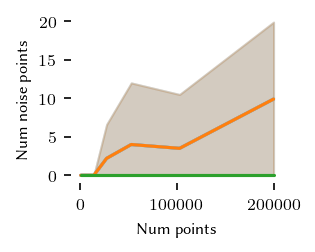

In [9]:
nu_dims = len(num_dims)
ylim = [80, 80, 80]
ticks = [[0, 40, 80], [0, 40, 80], [0, 40, 80]]
for i, nd in enumerate(num_dims):
    sized_fig(1/nu_dims, aspect=0.8)
    sns.lineplot(melt.query(f'num_dims == {nd}').rename(**display_names), 
                 x='Num points', y='Num noise points', hue='Algorithm', 
                 legend=False if i > 0 else "auto",
                 hue_order=[
                    "FLASC (full)", "FLASC (core)", "HDBSCAN*", "kMeans"
                 ],
                 palette=['C0', '#a6cee3', 'C1', 'C2'])
    if i == 0:
        l = plt.legend(loc='upper left', title_fontsize=6, fontsize=6)
        adjust_legend_subtitles(l)
    plt.show()

Only in two dimensions are there quite a few noise points. Still they remain
below 10% of the dataset, so that should be good enough for this comparison.

Now, the number of edges in the cluster approximation graph:

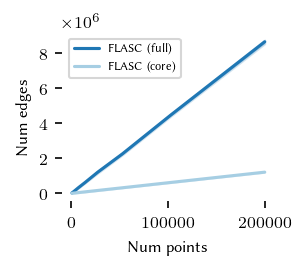

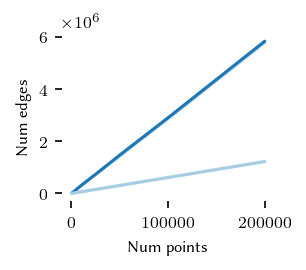

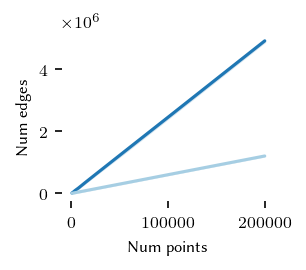

In [10]:
nu_dims = len(num_dims)
ylim = [80, 80, 80]
ticks = [[0, 40, 80], [0, 40, 80], [0, 40, 80]]
for i, nd in enumerate(num_dims):
    sized_fig(1/nu_dims, aspect=0.8)
    sub = melt.query(f'num_dims == {nd}').rename(**display_names)
    sns.lineplot(sub, x='Num points', y='Num edges', hue='Algorithm', 
                 legend=False if i > 0 else "auto",
                 hue_order=[
                    "FLASC (full)", "FLASC (core)"
                 ],
                 palette=['C0', '#a6cee3'])
    if i == 0:
        l = plt.legend(loc='upper left', title_fontsize=6, fontsize=6)
        adjust_legend_subtitles(l)
    plt.show()

As expected, the *core* detection method uses many fewer edges, explaining the run-time differences between the algorithms.


Finaly, the speedup of both FLASC variants compared to HDBSCAN\* is shown below:
$$
speedup = \frac{time_{x}}{time_{hdbscan}}
$$

In [11]:
id_columns =  ['repeats', 'num_dims', 'num_clusters', 'num_points']
pivotted = melt.query("algorithm not in ['fastcluster', 'DBSCAN']").pivot(
    index=id_columns, 
    columns='algorithm', 
    values='run_times'
)

speedup = (pivotted['HDBSCAN*'].to_numpy()[None].T / pivotted.iloc[:, :-1])\
    .reset_index()\
    .melt(id_vars=id_columns, var_name='algorithm', value_name='speedup')

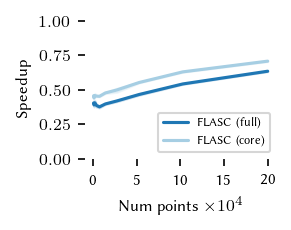

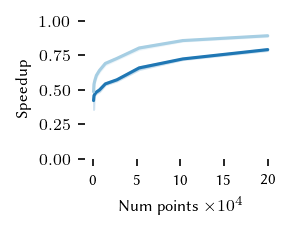

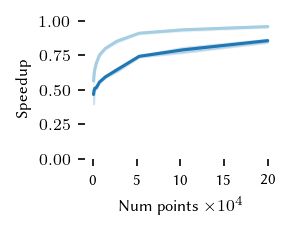

In [12]:
nu_dims = len(num_dims)
for i, nd in enumerate(num_dims):
    sized_fig(1/nu_dims, 0.8)
    sns.lineplot(
        speedup.query(f'num_dims == {nd}').rename(**display_names), 
        x='Num points', y='Speedup', hue='Algorithm',
        hue_order=['FLASC (full)', 'FLASC (core)'],
        palette=['C0', '#a6cee3'],
        legend=False if i != 0 else 'auto'
    )
    plt.ylim([0, 1])
    plt.gca().set_xticks([0, 50000, 100000, 150000, 200000])
    plt.gca().set_xticklabels(['0', '5', '10', '15', '20'])
    if i == 0:
        l = plt.legend(loc='lower right')
        adjust_legend_subtitles(l)
    plt.xlabel('Num points $\\times 10^4$')
    plt.ylabel('Speedup')
    plt.subplots_adjust(0.28, 0.32, 0.98, 0.95, 0, 0)
    plt.savefig(f'./images/relative_run_times_{nd}_dims.png')
plt.show()

These figures indicate that the extra cost of FLASC decreases with the number of
dimensions, especially for the *core* detection method. At 2 dimensions FLASC
takes less than 2 as long on larger datasets.